# Results
We compare quality of each model by using F1_score as ultimate score, and here results

|model|f_1 score|
|---|---|
|knn|0.693   |
|Logistic Regression|0.688|
|XGBoost Classifier|0.838|
|Lazy FCA|0.710|

In [99]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import warnings
from tqdm import tqdm_notebook
warnings.filterwarnings('ignore')

%matplotlib inline

# Explore data

We work with binary 10x10 images with labels:
- 1 - if white pixels on image are connected
- 0 - if white pixels on image are disconnected because of black pixels that created borders between them

In [6]:
frame = pd.read_csv('p=0.2123_10x10_10^4_images')
frame['100'] = [1 if x == 1 else 0 for x in frame['100']] 
print(frame['100'].mean())
frame.head()

0.5038


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,1,1,1,0,0,1,1,1,1,1,...,1,1,1,1,1,1,0,1,1,1
1,1,0,1,0,1,0,1,0,0,0,...,1,1,1,0,1,0,1,0,0,0
2,1,1,0,1,0,1,1,1,1,1,...,1,1,1,0,0,1,1,1,0,1
3,1,1,1,0,0,1,1,1,0,1,...,1,1,1,1,0,1,1,1,0,1
4,1,0,0,1,0,1,1,1,1,1,...,1,1,0,0,0,1,0,1,0,0


In [7]:
X = frame.drop('100', axis = 1)
y = frame['100']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

label 0 - means that not all white particles connected


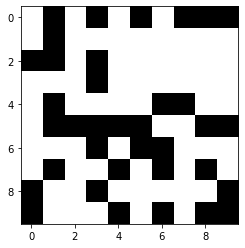

Here we can see 4 different white components


In [198]:
print('label', y[1], '- means that not all white particles connected')
plt.imshow(np.reshape(X.iloc[1].values, (10, 10)), cmap='gray', interpolation='nearest') 
plt.show()
print('Here we can see 4 different white components')

# KNN

In [30]:
%%time
knn = KNeighborsClassifier(n_neighbors=15, p=1)
knn.fit(X_train, y_train)

CPU times: user 64.5 ms, sys: 3.41 ms, total: 67.9 ms
Wall time: 67.4 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=1,
                     weights='uniform')

In [32]:
%%time
print(f1_score(y_test[:part], knn.predict(X_test[:part])))

0.6930826057756883
CPU times: user 1.26 s, sys: 9.24 ms, total: 1.27 s
Wall time: 1.28 s


# Линейные методы

In [37]:
log = LogisticRegression()
param_grid_log = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.1, 1, 10]}
optimizer = GridSearchCV(log, param_grid_log, scoring='f1', n_jobs=-1, cv = 3)

In [76]:
%%time
optimizer.fit(X_train, y_train)
print('logisticRegresiion f1 test', f1_score(y_test, optimizer.predict(X_test)))

logisticRegresiion f1 test 0.6888128969223253
CPU times: user 4.68 s, sys: 33.4 ms, total: 4.71 s
Wall time: 11.3 s


# XGBoost

In [49]:
%%time
xgb = XGBClassifier(n_estimators=1250)
xgb.fit(X_train, y_train)
print('xgb f1 train:', f1_score(y_train, xgb.predict(X_train)))
print('xgb f1 test:', f1_score(y_test, xgb.predict(X_test)))

xgb f1 train: 0.9424650938854117
xgb f1 test: 0.8386180785612873
CPU times: user 29.4 s, sys: 52.8 ms, total: 29.4 s
Wall time: 29.5 s


# Lazy fca

In [182]:
class LazyFCA:
    def __init__(self, threshold):
        self.threshold = threshold
    
    def fit(self, X_train, y_train):
        self.X = X_train.values
        self.y = y_train.values
        
    def predict(self, X):
        X = X.values
        result = []
        for x_test in X:
            inters = ((self.X == x_test).sum(axis=1) >= self.threshold)
            result.append(1 if (inters * (self.y - 0.5)).sum() > 0 else 0)
        return np.array(result)

In [190]:
%%time
part = 1000
fca_train = []
fca_test = []
thrs = [70, 75, 77, 78, 79, 80, 81, 82]
for thr in tqdm_notebook(thrs):
    fca = LazyFCA(thr)
    fca.fit(X_train, y_train)
    fca_train.append(f1_score(y_train[:part], fca.predict(X_train[:part])))
    fca_test.append(f1_score(y_test, fca.predict(X_test)))


CPU times: user 26.9 s, sys: 136 ms, total: 27 s
Wall time: 27 s


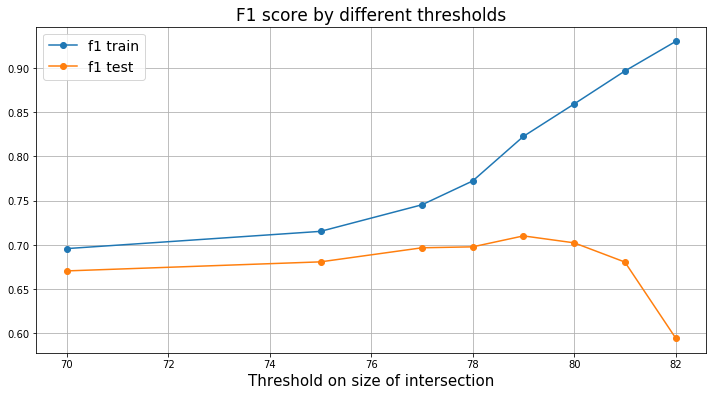

In [191]:
plt.figure(figsize=(12, 6))
plt.title('F1 score by different thresholds', fontsize=17)
plt.grid()
plt.xlabel('Threshold on size of intersection', fontsize=15)
plt.plot(thrs, fca_train, '-o', label='f1 train')
plt.plot(thrs, fca_test, '-o', label='f1 test')
plt.legend(prop={'size': 14})
plt.show()

In [196]:
print(f'Best score on test sample = {np.max(fca_test):.2f}')

Best score on test sample = 0.71
